In [3]:
#dependencies for visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import importlib

sys.path.append(os.path.abspath(".."))
import misc
importlib.reload(misc)
from misc import load_csv_dataset

data = load_csv_dataset("names.csv")
df = pd.DataFrame(data)

In [4]:
#breakdown of names into surname, middle name and first name
#constraint: take into account compound names (eg. ILUNGA WA ILUNGA MARC)
#            take into account missing names (eg. LOKUA KANZA, KASONGO GERMAINE)

df['split'] = df['name'].str.strip().str.split()
df = df[df['split'].notna() & df['split'].str.len() > 0]
df['surname'] = df['split'].apply(lambda x: x[0] if len(x) >= 1 else "null")
df['first_name'] = df['split'].apply(lambda x: x[-1] if len(x) >= 2 else "null")
df['middle_name'] = df['split'].apply(lambda x: ' '.join(x[1:-1]) if len(x) > 2 else "null")
df.drop(columns=['split'], inplace=True)
df[['name', 'surname', 'middle_name', 'first_name']].head()

,name,surname,middle_name,first_name
0,DIKOKO PAMITSHEFU FABRICE,DIKOKO,PAMITSHEFU,FABRICE
1,EPENGE DJONGESONGO JONAS,EPENGE,DJONGESONGO,JONAS
2,EYONGOYONGO SHAKO MICHEL,EYONGOYONGO,SHAKO,MICHEL
3,KASSONGO OSANGO ISRAEL,KASSONGO,OSANGO,ISRAEL
4,OKAWONGA ONGONDJO ALPHONSE,OKAWONGA,ONGONDJO,ALPHONSE


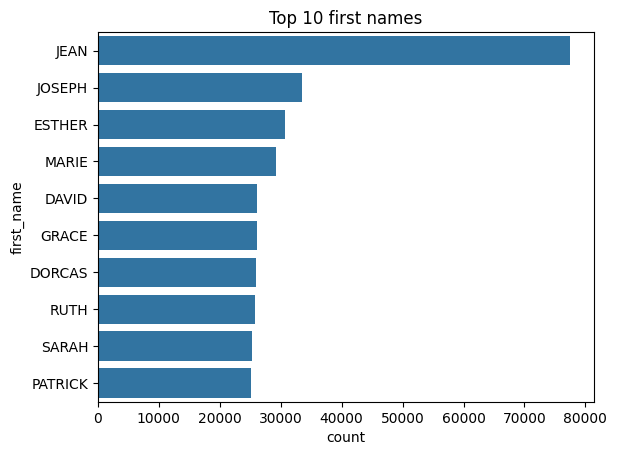

In [5]:
# Simple distribution of first names (display of the 10 most popular first names)
sns.countplot(y=df['first_name'], order=df['first_name'].value_counts().iloc[:10].index)
plt.title("Top 10 first names")
plt.show()

In [6]:
firstnames = df['first_name'].value_counts()
df_firstnames = firstnames.reset_index()
df_firstnames.columns = ['FIrst name', 'quantity']
df_firstnames.head(10)

,FIrst name,quantity
0,JEAN,77520
1,JOSEPH,33433
2,ESTHER,30778
3,MARIE,29289
4,DAVID,26122
5,GRACE,26120
6,DORCAS,25999
7,RUTH,25734
8,SARAH,25275
9,PATRICK,25146


In [7]:
# Total number of distinct first names
total_firstnames = df['first_name'].notna().sum()
print(f">> Total number of first names registered : {total_firstnames}")

# categorization of first names
firstnames_by_sex = df.groupby(['first_name', 'sex']).size().unstack(fill_value=0)
male_firstnames = firstnames_by_sex[(firstnames_by_sex['M'] > 0) & (firstnames_by_sex['F'] == 0)]
print(f">> Number of all-male first names : {len(male_firstnames)}")
female_firstnames = firstnames_by_sex[(firstnames_by_sex['F'] > 0) & (firstnames_by_sex['M'] == 0)]
print(f">> Number of all-female first names : {len(female_firstnames)}")
neutral_firstnames = firstnames_by_sex[(firstnames_by_sex['M'] > 0) & (firstnames_by_sex['F'] > 0)]
print(f">> Number of all-neutral first names : {len(neutral_firstnames)}")


>> Total number of first names registered : 4259141
>> Number of all-male first names : 128856
>> Number of all-female first names : 70806
>> Number of all-neutral first names : 31849


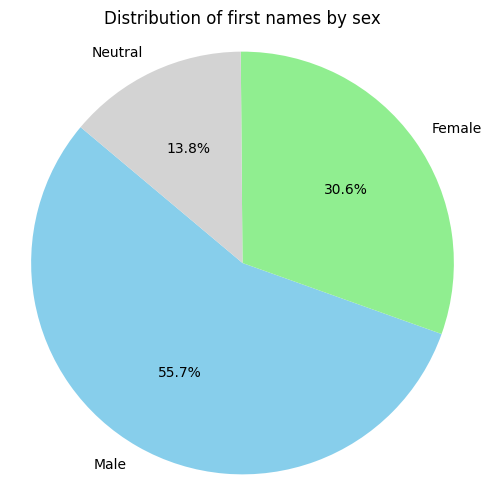

In [8]:
# data for graphic interpretation 
labels = ['Male', 'Female', 'Neutral']
values = [len(male_firstnames), len(female_firstnames), len(neutral_firstnames)]

# circular
plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'lightgray'])
plt.title("Distribution of first names by sex")
plt.axis('equal')
plt.show()

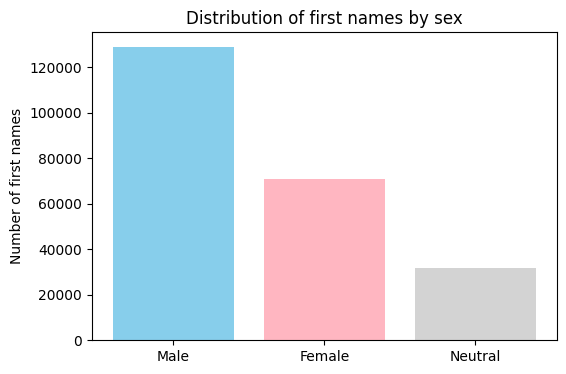

In [9]:
# Histogram
plt.figure(figsize=(6,4))
plt.bar(labels, values, color=['skyblue', 'lightpink', 'lightgray'])
plt.title("Distribution of first names by sex")
plt.ylabel("Number of first names")
plt.show()

In [10]:
# Count of unique first names per region
distinct_regions = df['region'].nunique()
print(f">> Number of distinct regions: {distinct_regions}")
firstnames_by_region = df.groupby('region')['first_name'].nunique().sort_values(ascending=False)

print("Number of unique first names per region")
df_firstnames_region = firstnames_by_region.reset_index()
df_firstnames_region.columns = ['Region', 'Unique first names']
df_firstnames_region.head(125)


>> Number of distinct regions: 124
Number of unique first names per region


,Region,Unique first names
0,kinshasa,45722
1,sud-kivu,22153
2,bandundu,20570
3,kinshasa-centre,20115
4,haut-katanga-1,19735
...,...,...
119,province-orientale-3,230
120,recours,95
121,junacyc-lualaba-corrige,46
122,lualaba-74-corrige-922a,18


In [11]:
# top 3 most popular first names by region
grouped = df.groupby(['region', 'first_name']).size().reset_index(name='count')
grouped = grouped.sort_values(['region', 'count'], ascending=[True, False])
top3_by_region = grouped.groupby('region').head(3)
for region, group in top3_by_region.groupby('region'):
    print(f"{region}")
    for _, row in group.iterrows():
        print(f"    {row['first_name']:<15} {row['count']}")
    print()

bandundu
    JEAN            1568
    TRESOR          506
    JOEL            452

bandundu-1
    JEAN            890
    JOEL            335
    HERITIER        247

bandundu-2
    JEAN            260
    TRESOR          109
    JOEL            92

bandundu-3
    null            61
    TEBA            31
    JEAN            29

bas-congo
    JEAN            829
    JOSEPH          543
    ANDRE           342

bas-congo-1
    JEAN            452
    JOSEPH          367
    MARIE           244

bas-congo-2
    JEAN            280
    DIEU            156
    CHRISTIAN       124

bas-fleuve
    JEAN            210
    JOSEPH          173
    DORCAS          148

bas-uele
    JEAN            255
    MOISE           123
    JOSEPH          114

cataractes
    JEAN            83
    JONATHAN        70
    GLOIRE          66

equateur
    JEAN            2113
    JOSEPH          962
    MICHEL          575

equateur-1
    JEAN            1163
    JEREMIE         533
    DIEU            491

e

In [12]:
#Group by region, gender and first name, then count
def determine_sex_category(row):
    if row['first_name'] in neutral_firstnames:
        return 'Neutral'
    return row['sex']

df['sex_category'] = df.apply(determine_sex_category, axis=1)

grouped = df.groupby(['region', 'sex_category', 'first_name']).size().reset_index(name='count')
grouped = grouped.sort_values(['region', 'sex_category', 'count'], ascending=[True, True, False])
top3_by_region_sex = grouped.groupby(['region', 'sex_category']).head(3)
for (region, sex), group in top3_by_region_sex.groupby(['region', 'sex_category']):
    print(f"{region.upper()} - {sex}")
    for _, row in group.iterrows():
        print(f"    {row['first_name']:<15} {row['count']}")
    print()

BANDUNDU - F
    MARIE           238
    NICLETTE        238
    JUDITH          217

BANDUNDU - M
    JEAN            1560
    TRESOR          504
    JOEL            431

BANDUNDU - Neutral
    M               49
    F               20

BANDUNDU-1 - F
    NICLETTE        124
    RACHEL          104
    MARIE           101

BANDUNDU-1 - M
    JEAN            884
    JOEL            332
    HERITIER        247

BANDUNDU-1 - Neutral
    M               12
    F               3

BANDUNDU-2 - F
    ESTHER          83
    MARIE           78
    RACHEL          62

BANDUNDU-2 - M
    JEAN            259
    TRESOR          109
    HERITIER        88

BANDUNDU-2 - Neutral
    M               8
    F               7

BANDUNDU-3 - F
    MARIE           12
    null            11
    DORCAS          7

BANDUNDU-3 - M
    null            50
    JEAN            29
    TEBA            27

BANDUNDU-3 - Neutral
    M               1

BAS-CONGO - F
    MARIE           336
    THERESE         164
    N